/var/folders/n2/fm6sdglj7ys6t3b8yg12ybwr0000gn/T/ipykernel_43813/2969866538.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['weekday'] = filtered_data['d'] % 7  # 取模7得到星期
/var/folders/n2/fm6sdglj7ys6t3b8yg12ybwr0000gn/T/ipykernel_43813/2969866538.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour_of_day'] = filtered_data['t'] // 2  # 小時


Epoch 0, Loss: 3413.2854
Epoch 100, Loss: 1500.2120
Epoch 200, Loss: 895.6320
Epoch 300, Loss: 793.5501
Epoch 400, Loss: 860.8943
Epoch 500, Loss: 679.8574
Epoch 600, Loss: 564.9146
Epoch 700, Loss: 587.7511
Epoch 800, Loss: 547.7041
Epoch 900, Loss: 544.4730
Mean Squared Error (MSE): 52247223.65
Mean Absolute Error (MAE): 5404.47


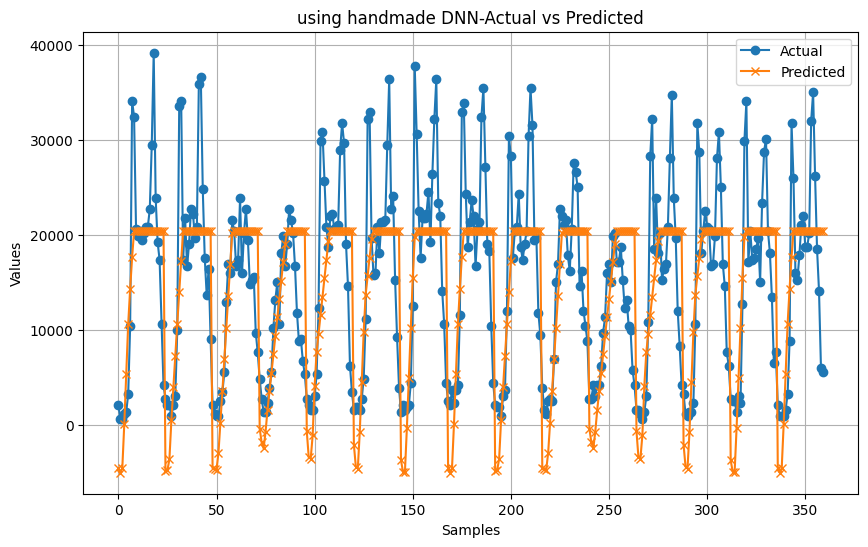

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# 激活函數與其導數
def relu(Z):
    return np.maximum(0, Z)
def relu_derivative(Z):
    return Z > 0

# 初始化權重與偏差
def initialize_parameters(input_dim, hidden_units, output_dim):
    np.random.seed(42)
    parameters = {
        "W1": np.random.randn(input_dim, hidden_units) * 0.01,
        "b1": np.zeros((1, hidden_units)),
        "W2": np.random.randn(hidden_units, output_dim) * 0.01,
        "b2": np.zeros((1, output_dim))
    }
    return parameters

# 前向傳播
def forward_propagation(X, parameters):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = Z2  # 回歸問題直接輸出
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

# 損失函數 (均方誤差)
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    loss = (1 / (2 * m)) * np.sum((y_pred - y_true) ** 2)
    return loss

# 反向傳播
def backward_propagation(X, y, cache, parameters):
    m = X.shape[0]
    W2 = parameters["W2"]
    A1, A2 = cache["A1"], cache["A2"]
    dZ2 = A2 - y
    dW2 = (1 / m) * np.dot(A1.T, dZ2)
    db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)
    dZ1 = np.dot(dZ2, W2.T) * relu_derivative(cache["Z1"])
    dW1 = (1 / m) * np.dot(X.T, dZ1)
    db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)
    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return gradients

# 更新參數
def update_parameters(parameters, gradients, learning_rate):
    parameters["W1"] -= learning_rate * gradients["dW1"]
    parameters["b1"] -= learning_rate * gradients["db1"]
    parameters["W2"] -= learning_rate * gradients["dW2"]
    parameters["b2"] -= learning_rate * gradients["db2"]
    return parameters

# 資料處理與切割
def data_processing(data,x,y):
    # 過濾 x=80, y=95 的資料
    filtered_data = data[(data['x'] == x) & (data['y'] == y)]

    # 計算星期與時間 (0:星期一 ~ 6:星期日)
    filtered_data['weekday'] = filtered_data['d'] % 7  # 取模7得到星期
    filtered_data['hour_of_day'] = filtered_data['t'] // 2  # 小時

    # 根據星期與時間分組，統計每組人數
    grouped_data = filtered_data.groupby(['d', 'weekday', 'hour_of_day']).size().reset_index(name='count')

    # 切割資料集：前 60 天為訓練集，後 20 天為驗證集
    train_data = grouped_data[grouped_data['d'] <= 59]  # 前 60 天的資料
    val_data = grouped_data[grouped_data['d'] > 59]     # 後 20 天的資料

    # 整理輸入特徵與標籤
    X_train = train_data[['weekday', 'hour_of_day']].values  # 特徵：星期與小時
    y_train = train_data['count'].values.reshape(-1, 1)      # 標籤：人數

    X_val = val_data[['weekday', 'hour_of_day']].values      # 驗證集特徵
    y_val = val_data['count'].values.reshape(-1, 1)         # 驗證集標籤

    # 標準化資料
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_x.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)

    X_val_scaled = scaler_x.transform(X_val)  # 使用相同的縮放器進行驗證集標準化
    y_val_scaled = scaler_y.transform(y_val)
    
    return X_train, X_val, y_train, y_val, scaler_x, scaler_y

# 訓練神經網路
def train_neural_network(X_train, y_train, input_dim, hidden_units, output_dim, epochs, learning_rate):
    parameters = initialize_parameters(input_dim, hidden_units, output_dim)
    for epoch in range(epochs):
        # Forward
        y_pred, cache = forward_propagation(X_train, parameters)
        
        # Loss
        loss = compute_loss(y_train, y_pred)
        
        # Backward
        gradients = backward_propagation(X_train, y_train, cache, parameters)
        
        # Update
        parameters = update_parameters(parameters, gradients, learning_rate)
        
        # Logging
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    return parameters

# 測試模型
def test_model(X_val, y_val, parameters, scaler_y):
    y_pred, _ = forward_propagation(X_val, parameters)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred)
    y_val_rescaled = scaler_y.inverse_transform(y_val)
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    mse = mean_squared_error(y_val_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    
    return y_pred_rescaled, y_val_rescaled
# 可視化結果
def draw_plot(y_val_rescaled, y_pred_rescaled):
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_rescaled, label='Actual', marker='o')
    plt.plot(y_pred_rescaled, label='Predicted', marker='x')
    plt.title("using handmade DNN-Actual vs Predicted")
    plt.xlabel("Samples")
    plt.ylabel("Values")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function
def main():
    # 讀取資料
    data = pd.read_csv('city_challengedata.csv')  # 確保資料檔案正確
    # 輸入要分析的地點資料
    x = 80
    y = 95

    # 1. 資料處理與切割
    X_train, X_val, y_train, y_val, scaler_X, scaler_y = data_processing(data, 80, 95)
    
    # 2. 模型初始化
    input_dim = X_train.shape[1]#得到特徵數=2(星期與小時)
    hidden_units = 1024
    output_dim = 1
    learning_rate = 0.01
    epochs = 1000
    
    # 3. 訓練模型
    parameters = train_neural_network(X_train, y_train, input_dim, hidden_units, output_dim, epochs, learning_rate)
    
    # 4. 測試模型
    y_pred_rescaled, y_val_rescaled = test_model(X_val, y_val, parameters, scaler_y)
    
    # 5. 可視化結果
    draw_plot(y_val_rescaled, y_pred_rescaled)

if __name__ == "__main__":
    main()
